In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


## Unperturbed image

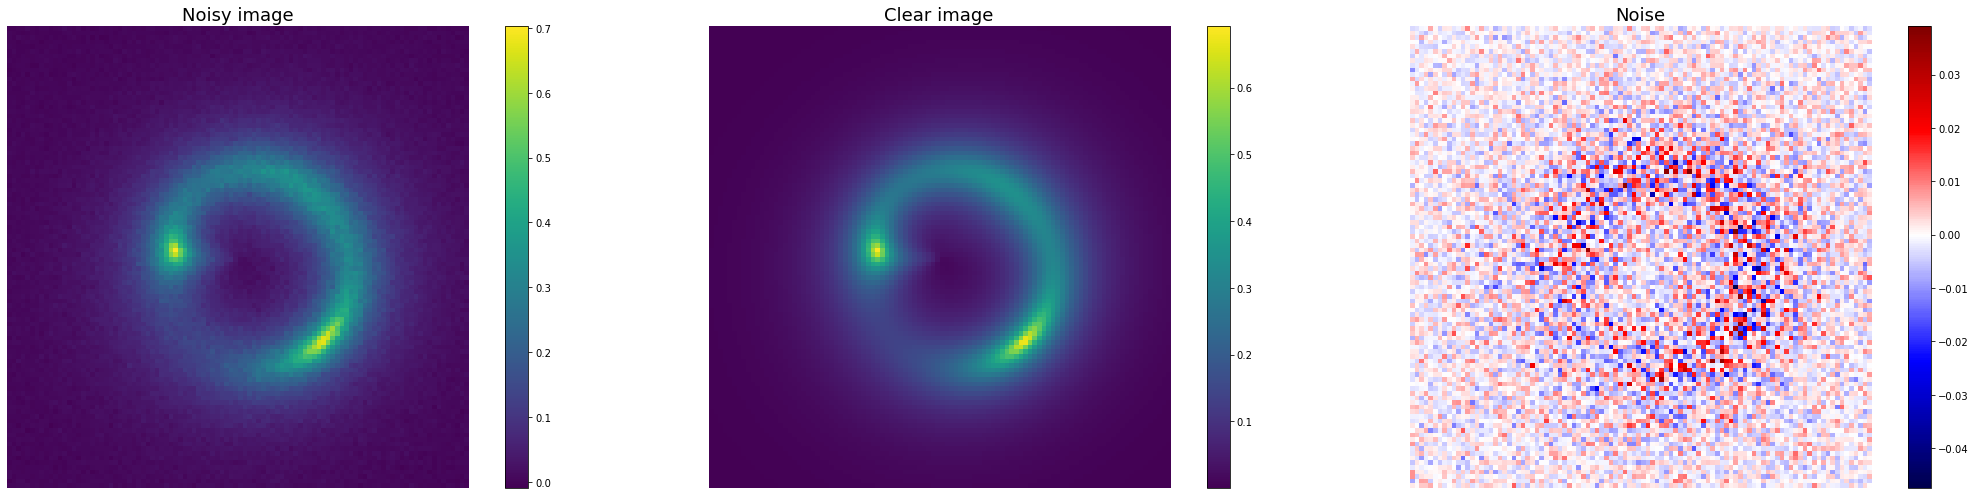

In [3]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

## Observed perturbed image

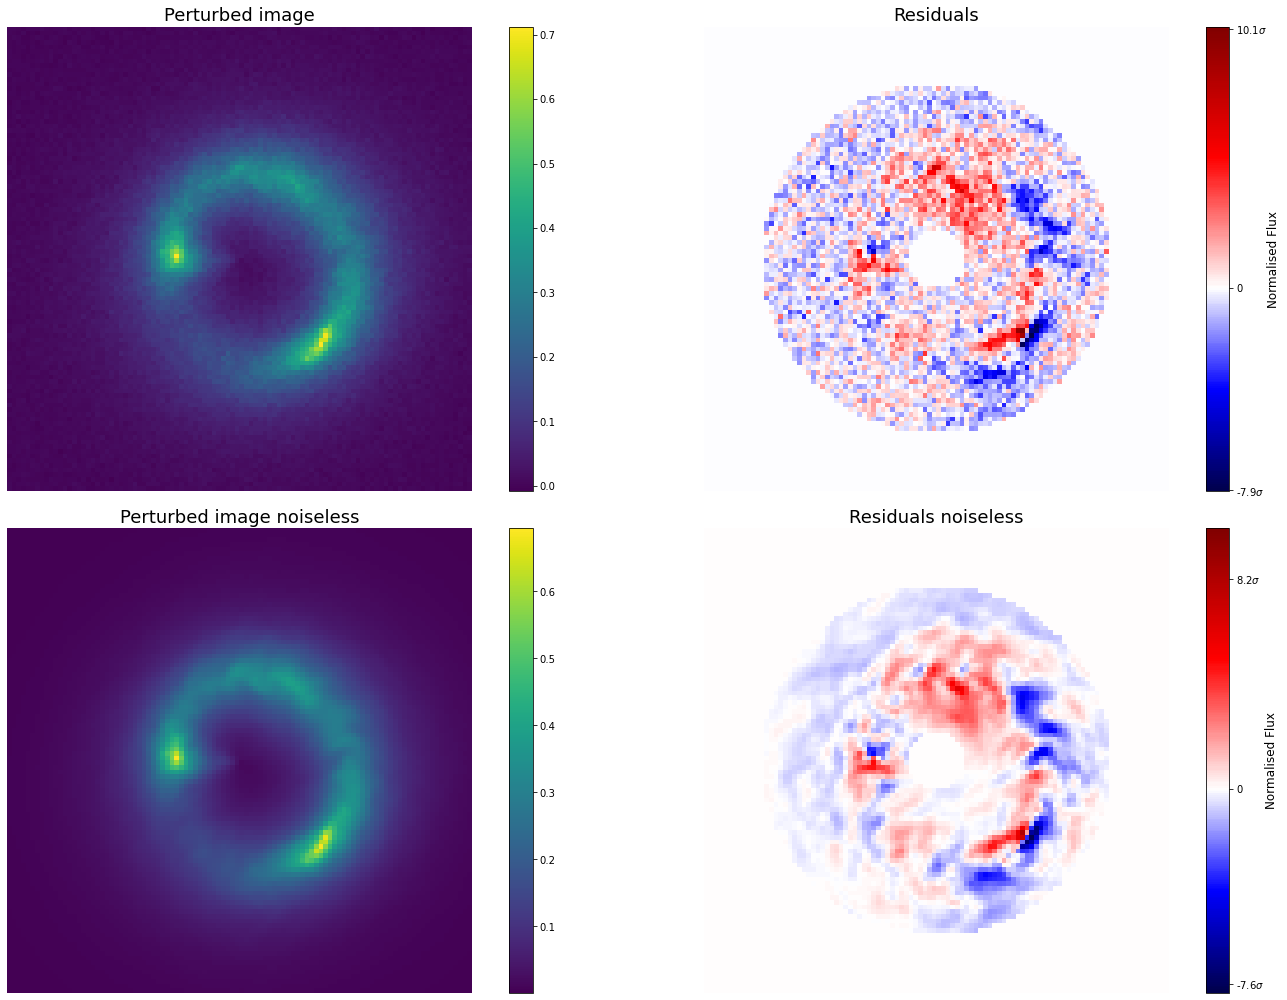

In [4]:
GRF_logA=-7.3
GRF_Beta=4.
GRF_seed_index=0

GRF_params=[GRF_logA,GRF_Beta]

get_GRF=Inference.GRF_getters
GRF_potential=get_GRF(GRF_params,GRF_seed_index)
data_noise_seed=np.round(GRF_potential[0,0]*1e+10).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
Image_perturbed_noiseless=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=False)
Image_perturbed_noisy=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=data_noise_seed)

fig,ax=plt.subplots(2,2,figsize=(20,14))

images=np.array([[Image_perturbed_noisy,Image_perturbed_noisy-Image_unperturbed_noiseless],[Image_perturbed_noiseless,Image_perturbed_noiseless-Image_unperturbed_noiseless]])

#Normalized masked residuals
images[:,1]/=np.sqrt(Observation_conditions.noise_var)
images[:,1]*=Observation_conditions.annulus_mask


titles=np.array([['Perturbed image','Residuals'],['Perturbed image noiseless','Residuals noiseless']])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(2):
        axis=axis_row[j]
        image=images[i,j]
        title=titles[i,j]
        
        if j==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1].min(),images[:,1].max()))
            colorborders=[math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1]
    
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders,fraction=0.045)
            cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
            cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.set_title(title,fontsize=FS)
        axis.axis('off')
plt.tight_layout()
plt.show()

# Data spectrum extraction

## Fit observed image to infer Source-Lens kwargs

In [5]:
args_fit=Inference.scipy_fit_image(Image_perturbed_noisy,method='trust-krylov',initial_values=Observation_conditions.parameters.initial_values())
fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

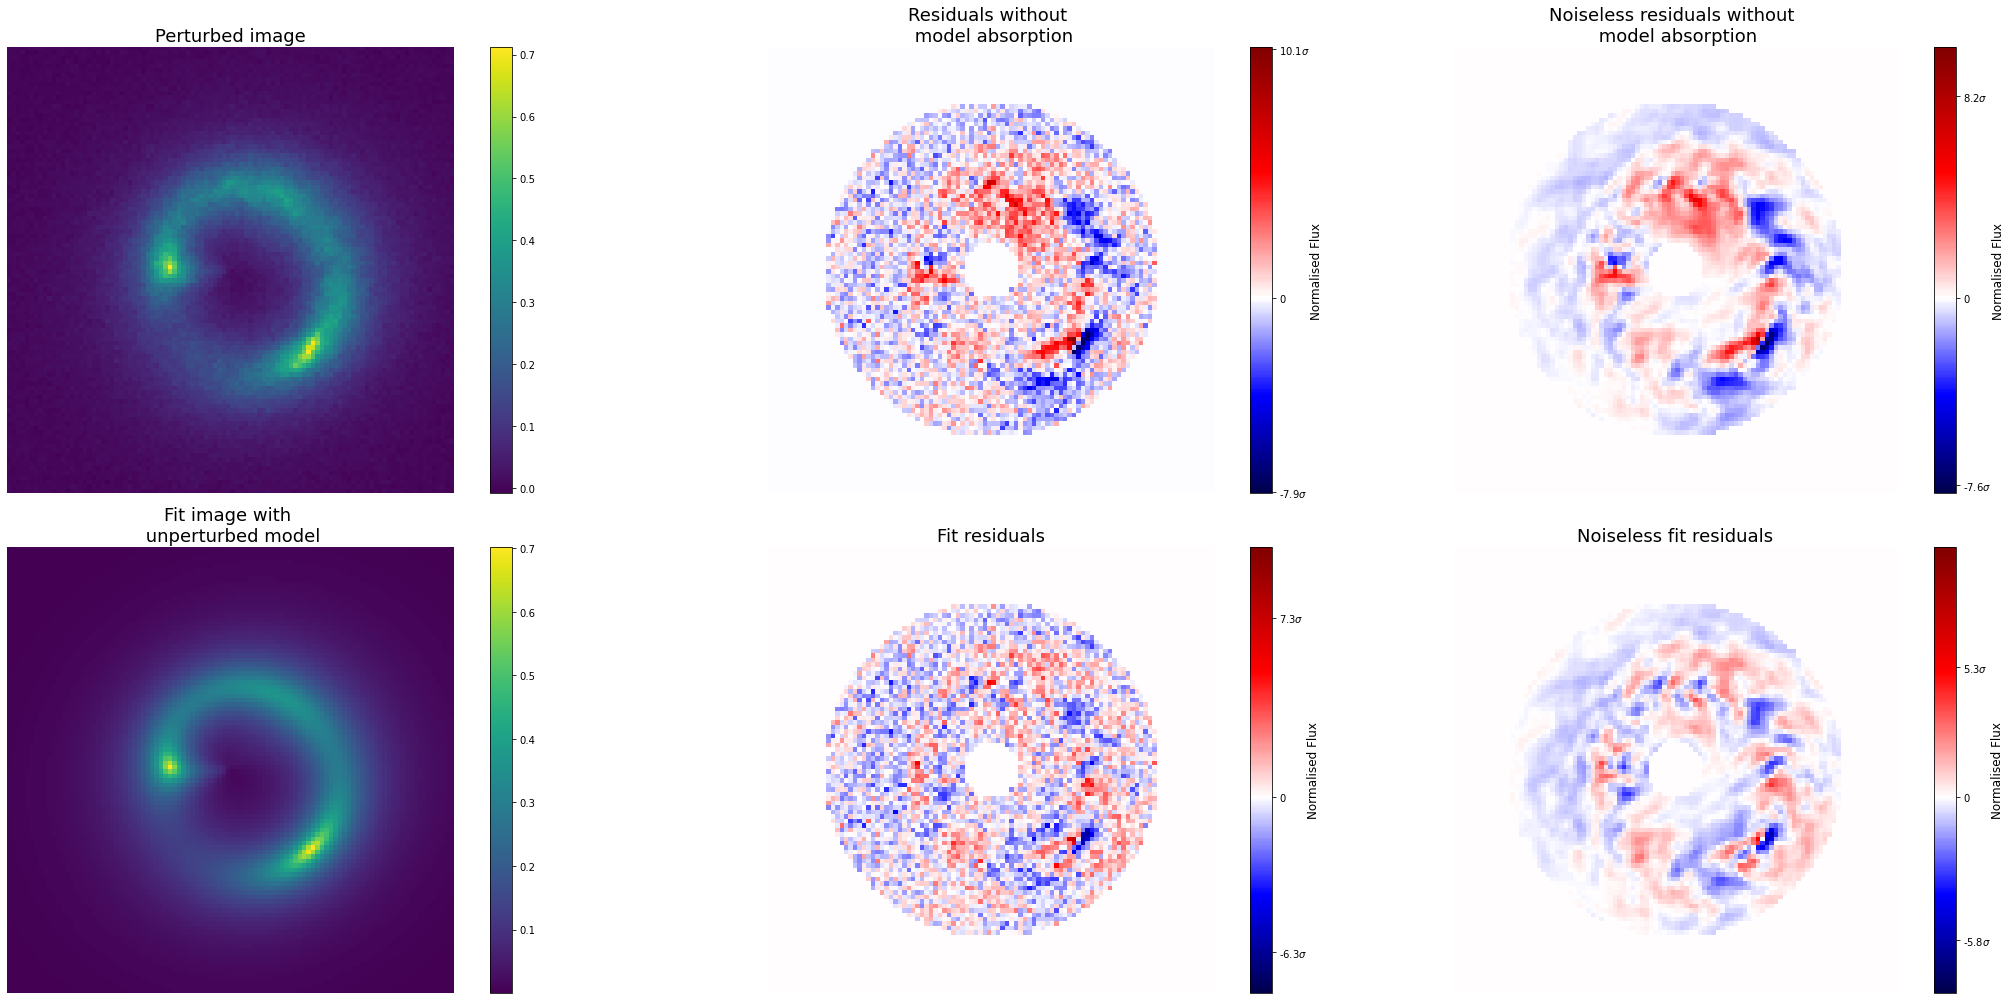

In [6]:
fig,ax=plt.subplots(2,3,figsize=(30,14))

images=np.array([[Image_perturbed_noisy,Image_perturbed_noisy-Image_unperturbed_noiseless,Image_perturbed_noiseless-Image_unperturbed_noiseless],\
                 [fit_image,Image_perturbed_noisy-fit_image,Image_perturbed_noisy-fit_image-(Image_perturbed_noisy-Image_perturbed_noiseless)]])

#Normalized masked residuals
images[:,1:]/=np.sqrt(Observation_conditions.noise_var)
images[:,1:]*=Observation_conditions.annulus_mask


titles=np.array([['Perturbed image','Residuals without \n model absorption','Noiseless residuals without \n model absorption'],\
                 ['Fit image with \n unperturbed model','Fit residuals','Noiseless fit residuals']])

for i in range(2):
    axis_row=ax[i]
    img_arr=[]
    for j in range(3):
        axis=axis_row[j]
        image=images[i,j]
        title=titles[i,j]
        
        if j==0:
            img=axis.imshow(image)
            fig.colorbar(img,ax=axis)
        else:
            img=axis.imshow(image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0,images[:,1:].min(),images[:,1:].max()))
            colorborders=[math.ceil(image.min()*1e+1)/1e+1,0,math.floor(image.max()*1e+1)/1e+1]
    
            cbar=fig.colorbar(img,ax=axis,ticks=colorborders,fraction=0.045)
            cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
            cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    
        axis.set_title(title,fontsize=FS)
        axis.axis('off')
plt.tight_layout()
plt.show()

## Differentiable fit

In [7]:
args_dif_fit=Inference.differentiable_fit_image(Image_perturbed_noisy,Observation_conditions.parameters.kwargs2args(Observation_conditions.kwargs_data))
dif_fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_dif_fit),Noise_flag=False)

Compilation took 35.10 seconds
How best fit loss would change if we change a pixel in fitted image?


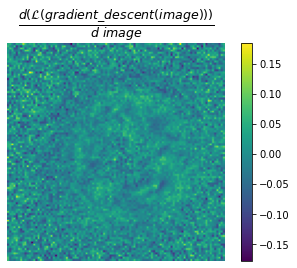

In [21]:
start_time=time.time()
dif_fit_pure=lambda image: Inference.image_loss(Inference.differentiable_fit_image(image,Observation_conditions.parameters.kwargs2args(Observation_conditions.kwargs_data)),image)
gradient_of_grad_descent=jax.grad(dif_fit_pure)(Image_perturbed_noisy)
print('Compilation took {:.2f} seconds'.format(time.time()-start_time))

print('How best fit loss would change if we change a pixel in fitted image?')

plt.imshow(gradient_of_grad_descent)
plt.colorbar()
plt.title(r'$\frac{d(\mathcal{L}(gradient\_descent(image)))}{d \ image}$',fontsize=FS)
plt.axis('off')
plt.show()

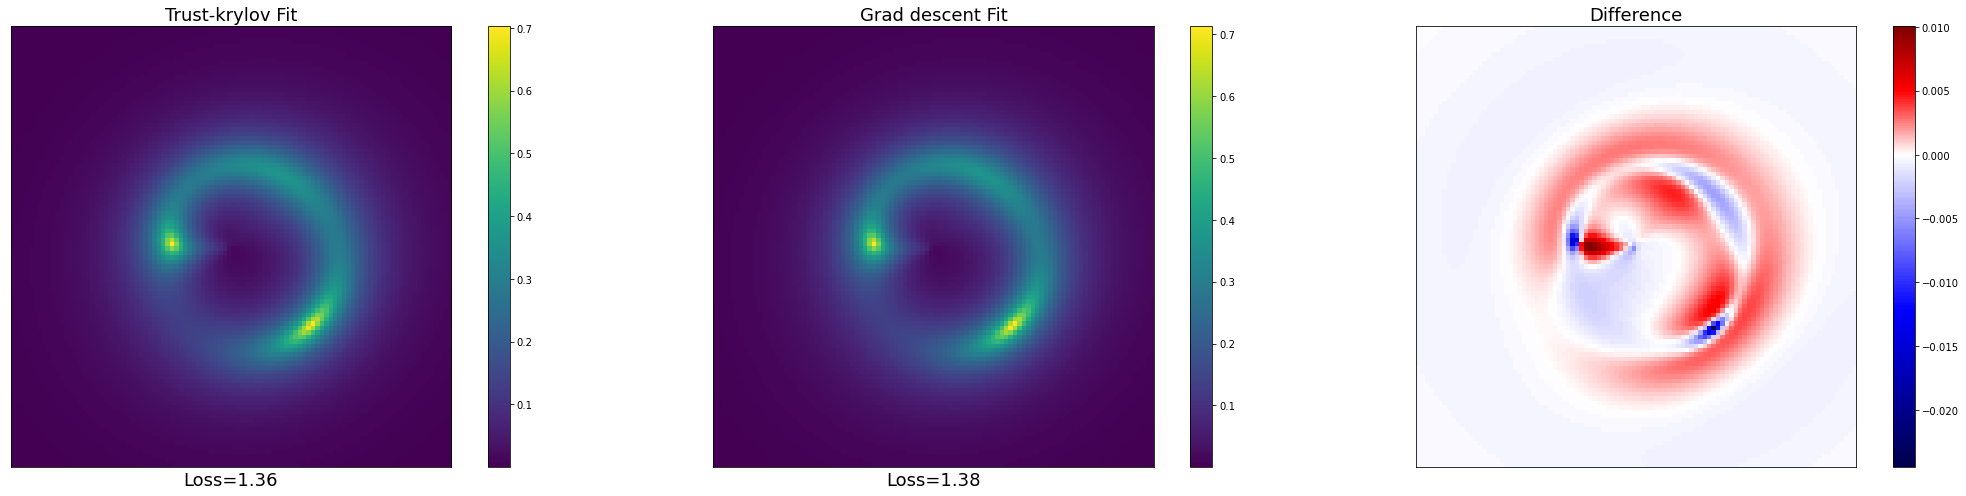

In [8]:
fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(fit_image)]
img_arr+=[ax[1].imshow(dif_fit_image)]
img_arr+=[ax[2].imshow(fit_image-dif_fit_image,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Trust-krylov Fit','Grad descent Fit','Difference']

ax[0].set_xlabel('Loss={:.2f}'.format(Inference.image_loss(args_fit,Image_perturbed_noisy)),fontsize=FS)
ax[1].set_xlabel('Loss={:.2f}'.format(Inference.image_loss(args_dif_fit,Image_perturbed_noisy)),fontsize=FS)


for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([])
    axis.set_yticks([])
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

# Power spectrum generation

In [7]:
true_spectrum=Inference.compute_radial_spectrum(Image_perturbed_noisy-fit_image)
true_noise_spectrum=Inference.compute_radial_spectrum(Image_perturbed_noisy-Image_perturbed_noiseless)
Estimated_Noise_spectral_density=(Observation_conditions.noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()
frequencies=Observation_conditions.frequencies

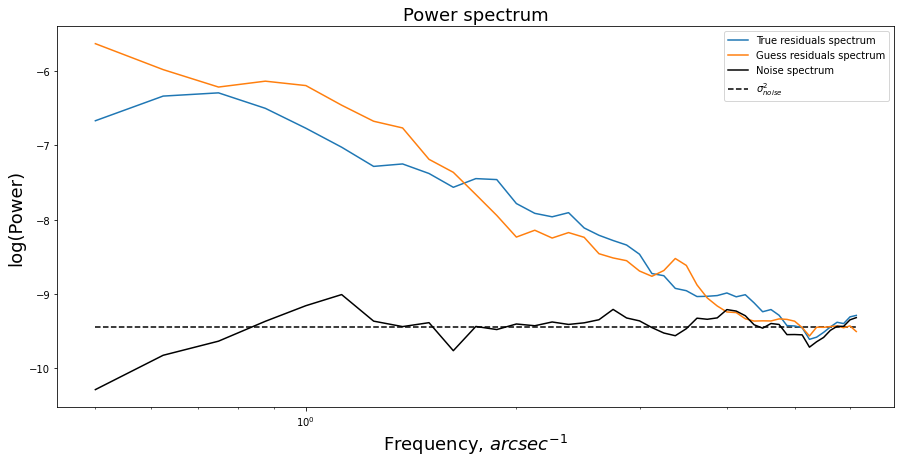

In [8]:
GRF_params_guess=[-7.3,4.]
Guess_spectrum=Inference.Residual_spectrum_for_GRF(GRF_params_guess,1,Noise=True)

plt.figure(figsize=(15,7))

plt.plot(frequencies,np.log(true_spectrum),label='True residuals spectrum')
plt.plot(frequencies,np.log(Guess_spectrum),label='Guess residuals spectrum')
plt.plot(frequencies,np.log(true_noise_spectrum),label='Noise spectrum',color='k')
plt.hlines(np.log(Estimated_Noise_spectral_density),frequencies[0],frequencies[-1],label=r'$\sigma^2_{noise}$',color='k',linestyle='--')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)

plt.legend()
plt.show()

# Power spectra distributions

In [13]:
'''Res_Spectra=np.zeros((100,len(frequencies)))

for i in tqdm(range(100)):
    Res_Spectra[i]=Inference.Residual_spectrum_for_GRF(GRF_params,i,Noise=True)
'''

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


NameError: name 'compute_radial_spectrum_pure' is not defined

In [14]:
#Noise_spectra=jax_map(Inference.compute_radial_spectrum,np.array([np.random.normal(0,np.sqrt(Observation_conditions.noise_var)) for i in tqdm(range(10000))]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3962.89it/s]


In [9]:
#np.savez('./data/Dummy_spectra',Res_spectra=Res_Spectra,Noise_spectra=Noise_spectra)
arr=np.load('./data/Dummy_spectra.npz')
Res_Spectra=arr['Res_spectra']
Noise_spectra=arr['Noise_spectra']

In [10]:
Spec_gamma,Spec_mu,Spec_sigma=infer_LogNorm_params(Res_Spectra)
Noise_gamma,Noise_mu,Noise_sigma=infer_LogNorm_params(Noise_spectra)

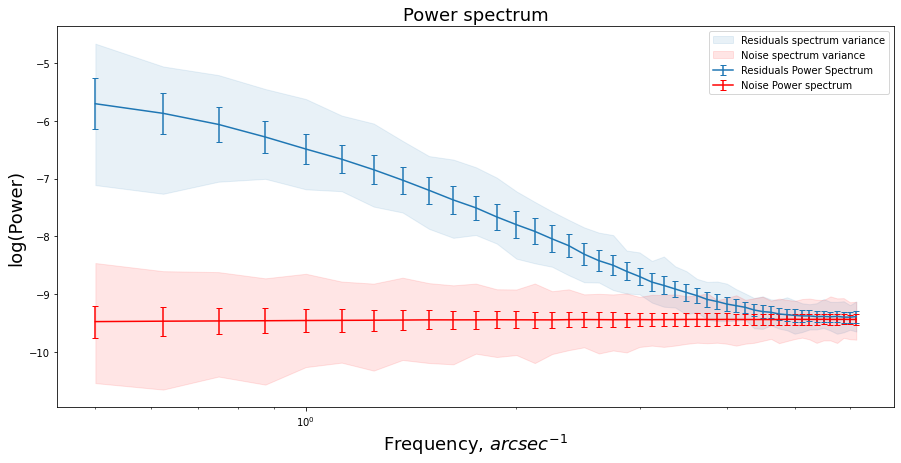

In [11]:
plt.figure(figsize=(15,7))

plt.errorbar(frequencies,Spec_mu,Spec_sigma,capsize=3,label='Residuals Power Spectrum',color='C0')
plt.fill_between(frequencies,np.log(Res_Spectra.min(axis=0)),np.log(Res_Spectra.max(axis=0)),color='C0',alpha=0.1,label='Residuals spectrum variance')

plt.fill_between(frequencies,np.log(Noise_spectra).min(axis=0),np.log(Noise_spectra).max(axis=0),color='r',alpha=0.1,label='Noise spectrum variance')
plt.errorbar(frequencies,Noise_mu,Noise_sigma,capsize=3,label='Noise Power spectrum',color='r')


plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)


plt.legend()
plt.show()

In [19]:
import scipy
def lognormal(xdata,*params):
    amplitude,s,loc,scale=params
    x=(xdata-loc)/scale
    return amplitude*scipy.stats.lognorm.pdf(x,s)

def normal_distr(xdata,*params):
    amplitude,mean,sigma=params
    
    return amplitude*np.exp(-(xdata-mean)**2/2/sigma**2)

def fit_likelihood(xdata,ydata,distr_func='lognormal',multiplier=None,Poisson_errs=False):
    
    #It is a trick to fit distributions in very small numbers here scipy just sets everyrhing to zero
    if multiplier:
        x=multiplier*xdata
    else:
        non_zero_xdata=xdata[np.where(xdata>0)[0]]
        multiplier=1/non_zero_xdata[0]
        x=multiplier*xdata
        
    if distr_func=='lognormal':
        func=lognormal
        init_guess=[1,1.,0.,1]
    elif distr_func=='normal':
        func=normal_distr
        init_guess=[1,x.mean(),x.std()]
    else:
        print('wrong distr_func')
        return None
    
        
    
    if Poisson_errs:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess,sigma=ydata)
    else:
        popt,pcov=scipy.optimize.curve_fit(func,x,ydata,init_guess)

    
    if distr_func=='lognormal':
        amplitude,s,loc,scale=popt
        return amplitude,s,loc/multiplier,scale/multiplier
    if distr_func=='normal':
        amplitude,mean,sigma=popt
        return amplitude,mean/multiplier,sigma/multiplier

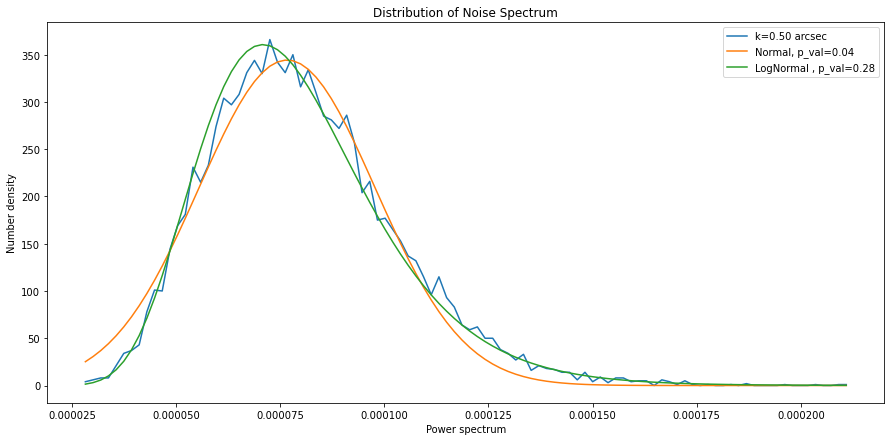

In [20]:
i=0

fig=plt.figure(figsize=(15,7))
data,x=np.histogram(Noise_spectra[:,i],bins=100)
    
lognorm_distr=lognormal(x[1:],*[1,Noise_sigma[i],0,np.exp(Noise_mu[i])])
lognorm_distr/=lognorm_distr.sum()
lognorm_distr*=data.sum()
    
try:
    popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
    norm_distr=normal_distr(x[1:],*popt)
except:
    print('Normal fit failed')

    

plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
plt.legend()
plt.ylabel('Number density')
plt.xlabel('Power spectrum')
plt.title('Distribution of Noise Spectrum')
plt.show()

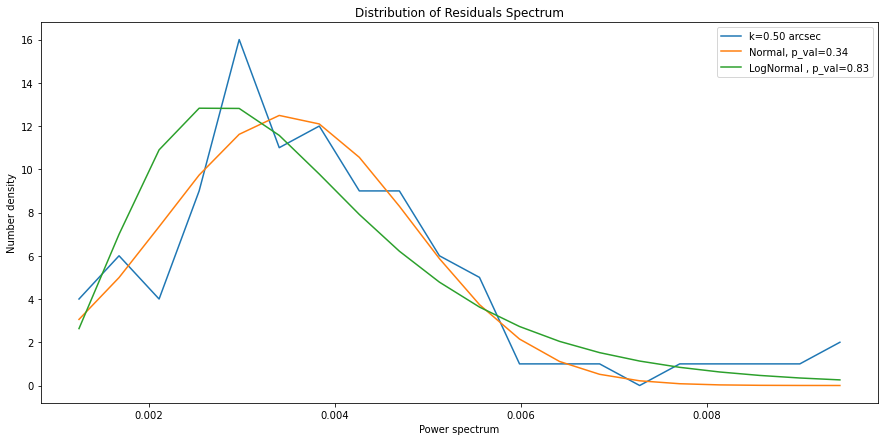

In [24]:
i=0

fig=plt.figure(figsize=(15,7))
data,x=np.histogram(Res_Spectra[:,i],bins=20)
    
lognorm_distr=lognormal(x[1:],*[1,Spec_sigma[i],0,np.exp(Spec_mu[i])])
lognorm_distr/=lognorm_distr.sum()
lognorm_distr*=data.sum()
    
try:
    popt=fit_likelihood(x[1:],data,distr_func='normal',Poisson_errs=False)
    norm_distr=normal_distr(x[1:],*popt)
except:
    print('Normal fit failed')

    

plt.plot(x[1:],data,label='k={:.2f} arcsec'.format(frequencies[i]))
plt.plot(x[1:],norm_distr,label='Normal, p_val={:.2f}'.format(scipy.stats.ks_2samp(data,norm_distr)[1]))
plt.plot(x[1:],lognorm_distr,label='LogNormal , p_val={:.2f}'.format(scipy.stats.ks_2samp(data,lognorm_distr)[1]))
plt.legend()
plt.ylabel('Number density')
plt.xlabel('Power spectrum')
plt.title('Distribution of Residuals Spectrum')
plt.show()

# Loss function

In [12]:
logSpec_data=np.log(true_spectrum)
sigma_data=Spec_sigma

@jax.jit
def Spectra_Loss_pure(model_spectra):
    
    #Infer mu of LogNormal distr
    mean=jnp.mean(model_spectra,axis=0)
    variance=jnp.power(jnp.std(model_spectra,axis=0),2)
    sigma_model=jnp.sqrt(jnp.log(1+variance/jnp.power(mean,2)))
    mu_model=jnp.log(mean)-jnp.power(sigma_model,2)/2
        
    #-LogLikelihood for Log Normal distribution    
    chi_sq=jnp.mean(jnp.power((logSpec_data-mu_model)/sigma_data,2))
    
    return chi_sq

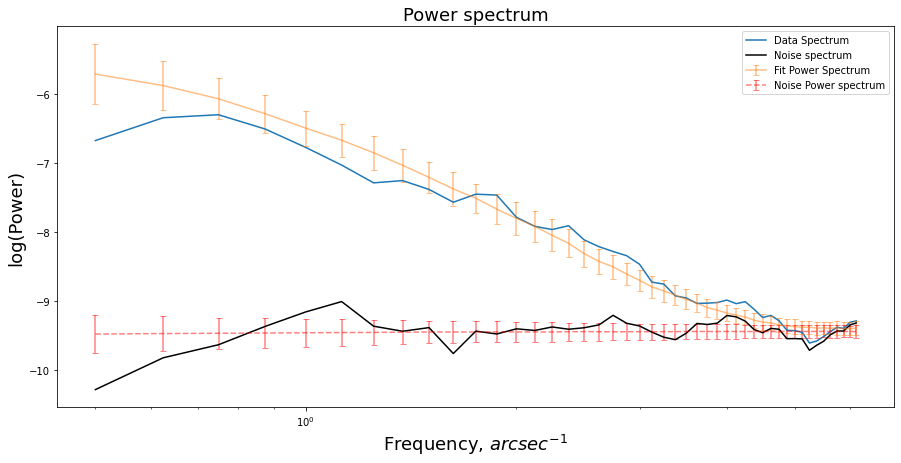

In [13]:
plt.figure(figsize=(15,7))

plt.plot(frequencies,logSpec_data,label='Data Spectrum')
plt.errorbar(frequencies,Spec_mu,Spec_sigma,capsize=3,label='Fit Power Spectrum',color='C1',alpha=0.5)

plt.errorbar(frequencies,Noise_mu,Noise_sigma,capsize=3,label='Noise Power spectrum',color='r',linestyle='--',alpha=0.5)
plt.plot(frequencies,np.log(true_noise_spectrum),label='Noise spectrum',color='k')



plt.xscale('log')

plt.ylabel('log(Power)',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title('Power spectrum',fontsize=FS)


plt.legend()
plt.show()

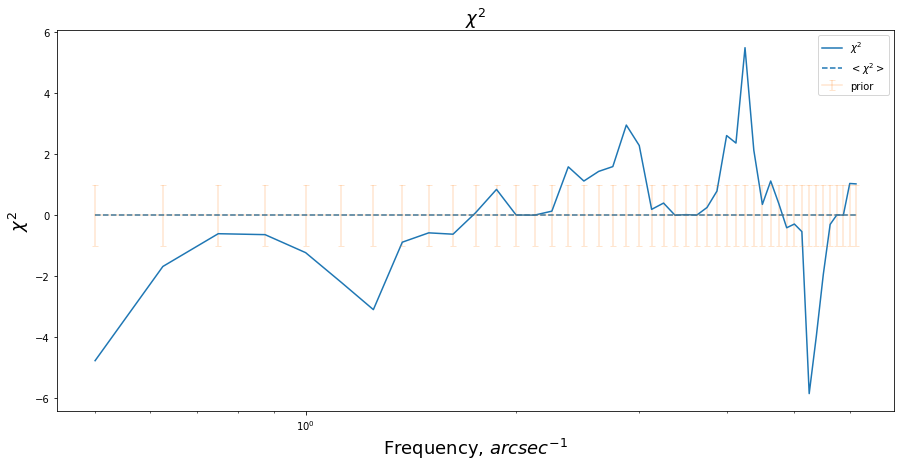

In [14]:
plt.figure(figsize=(15,7))

chisq=jnp.power((logSpec_data-Spec_mu)/sigma_data,2)*np.sign(logSpec_data-Spec_mu)
plt.plot(frequencies,chisq,label=r'$\chi^2$')
plt.plot(frequencies,chisq.mean()*np.ones_like(chisq),label=r'$<\chi^2>$',linestyle='--',color='C0')
#plt.hlines(chisq.mean(),frequencies[0],frequencies[-1],label=r'$<\chi^2>$',linestyle='--')
plt.errorbar(frequencies,np.zeros_like(frequencies),np.ones_like(frequencies),capsize=3,label='prior',color='C1',alpha=0.2)

plt.xscale('log')

plt.ylabel(r'$\chi^2$',fontsize=FS)
plt.xlabel('Frequency, '+r'$arcsec^{-1}$',fontsize=FS)
plt.title(r'$\chi^2$',fontsize=FS)


plt.legend()
plt.show()

# Differentiable loss

In [24]:
def GRF_Loss(GRF_params,GRF_seeds_number,Spectra_Loss_pure):

        GRF_seed_indices=np.arange(GRF_seeds_number)
        get_model_spectra=lambda GRF_seed_index: Inference.Residual_spectrum_for_GRF(GRF_params,GRF_seed_index)
        model_spectra=jax_map(get_model_spectra,GRF_seed_indices)

        Loss=Spectra_Loss_pure(model_spectra)
        return Loss
    

GRF_Loss_pure=jax.jit(lambda GRF_params: GRF_Loss(GRF_params,1,Spectra_Loss_pure))

In [25]:
start_time=time.time()
Loss=GRF_Loss_pure(GRF_params)
end_time=time.time()
print('Loss',Loss)
print('time',end_time-start_time)

TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=1/1)>
While tracing the function <lambda> at /Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Jax_Utils.py:68 for scan, this concrete value was not available in Python because it depends on the value of the argument 'x'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [35]:
start_time=time.time()
Loss=GRF_Loss_pure(GRF_params)
end_time=time.time()
print('Loss',Loss)
print('time',end_time-start_time)

Loss 0.6787363636065923
time 13.765196084976196


In [36]:
start_time=time.time()
Grad_Loss=jax.grad(GRF_Loss_pure)(GRF_params)
end_time=time.time()
print('Grad Loss',Grad_Loss)
print('time',end_time-start_time)

Grad Loss [DeviceArray(2.39832766, dtype=float64), DeviceArray(-0.12386563, dtype=float64, weak_type=True)]
time 247.84498286247253
